In [2]:
import sys
import stlearn as st
st.settings.set_figure_params(dpi=300)
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
file = Path("../stimage").resolve()
parent= file.parent
sys.path.append(str(parent))
from PIL import Image
from stimage.utils import gene_plot, Read10X, ReadOldST
from stimage.model import CNN_NB_trainable
from stimage.data_generator import DataGenerator
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [2]:
from typing import Optional, Union
from anndata import AnnData
from PIL import Image
from pathlib import Path

# Test progress bar
from tqdm import tqdm
import numpy as np
import os


def tiling(
    adata: AnnData,
    out_path: Union[Path, str] = "./tiling",
    library_id: str = None,
    crop_size: int = 40,
    target_size: int = 299,
    verbose: bool = False,
    copy: bool = False,
) -> Optional[AnnData]:
    """\
    Tiling H&E images to small tiles based on spot spatial location

    Parameters
    ----------
    adata
        Annotated data matrix.
    out_path
        Path to save spot image tiles
    library_id
        Library id stored in AnnData.
    crop_size
        Size of tiles
    verbose
        Verbose output
    copy
        Return a copy instead of writing to adata.
    target_size
        Input size for convolutional neuron network
    Returns
    -------
    Depending on `copy`, returns or updates `adata` with the following fields.
    **tile_path** : `adata.obs` field
        Saved path for each spot image tiles
    """

    if library_id is None:
        library_id = list(adata.uns["spatial"].keys())[0]

    # Check the exist of out_path
    if not os.path.isdir(out_path):
        os.mkdir(out_path)

    image = adata.uns["spatial"][library_id]["images"][adata.uns["spatial"]["use_quality"]]
    if image.dtype == np.float32 or image.dtype == np.float64:
        image = (image * 255).astype(np.uint8)
    img_pillow = Image.fromarray(image)
    tile_names = []

    with tqdm(
        total=len(adata),
        desc="Tiling image",
        bar_format="{l_bar}{bar} [ time left: {remaining} ]",
    ) as pbar:
        for imagerow, imagecol in zip(adata.obs["imagerow"], adata.obs["imagecol"]):
            imagerow_down = imagerow - crop_size / 2
            imagerow_up = imagerow + crop_size / 2
            imagecol_left = imagecol - crop_size / 2
            imagecol_right = imagecol + crop_size / 2
            tile = img_pillow.crop(
                (imagecol_left, imagerow_down, imagecol_right, imagerow_up)
            )
            #tile.thumbnail((target_size, target_size), Image.ANTIALIAS)
            tile = tile.resize((target_size, target_size))
            tile_name = library_id + "-" + str(imagecol) + "-" + str(imagerow) + "-" + str(crop_size)
            out_tile = Path(out_path) / (tile_name + ".jpeg")
            tile_names.append(str(out_tile))
            if verbose:
                print(
                    "generate tile at location ({}, {})".format(
                        str(imagecol), str(imagerow)
                    )
                )
            tile.save(out_tile, "JPEG")

            pbar.update(1)

    adata.obs["tile_path"] = tile_names
    return adata if copy else None


In [3]:
BASE_PATH=Path("/clusterdata/uqxtan9/Xiao/STimage/"
                "dataset/breast_cancer_oldST_STNet")
TILING_PATH= Path("/tmp/tile")
TILING_PATH.mkdir(parents=True, exist_ok=True)

In [4]:
meta = pd.read_csv(BASE_PATH / "metadata.csv")

In [5]:
meta

,type,patient,replicate,count_matrix,histology_image,spot_coordinates
0,HER2_luminal,BC23287,C1,BC23287_C1_stdata.tsv.gz,HE_BT23287_C1.jpg,spots_BT23287_C1.csv.gz
1,HER2_luminal,BC23287,C2,BC23287_C2_stdata.tsv.gz,HE_BT23287_C2.jpg,spots_BT23287_C2.csv.gz
2,HER2_luminal,BC23287,D1,BC23287_D1_stdata.tsv.gz,HE_BT23287_D1.jpg,spots_BT23287_D1.csv.gz
3,HER2_luminal,BC23450,D2,BC23450_D2_stdata.tsv.gz,HE_BT23450_D2.jpg,spots_BT23450_D2.csv.gz
4,HER2_luminal,BC23450,E1,BC23450_E1_stdata.tsv.gz,HE_BT23450_E1.jpg,spots_BT23450_E1.csv.gz
...,...,...,...,...,...,...
63,TNBC,BC23377,C2,BC23377_C2_stdata.tsv.gz,HE_BT23377_C2.jpg,spots_BT23377_C2.csv.gz
64,TNBC,BC23377,D1,BC23377_D1_stdata.tsv.gz,HE_BT23377_D1.jpg,spots_BT23377_D1.csv.gz
65,TNBC,BC23803,D2,BC23803_D2_stdata.tsv.gz,HE_BC23803_D2.jpg,spots_BC23803_D2.csv.gz
66,TNBC,BC23803,E1,BC23803_E1_stdata.tsv.gz,HE_BC23803_E1.jpg,spots_BC23803_E1.csv.gz


In [6]:
adata_list = []
for index,row in meta.iterrows():
    cm_path = BASE_PATH / "stdata" / row["count_matrix"].split(".gz")[0]
    spot_path = BASE_PATH / "spotinfo" / row["spot_coordinates"].split(".gz")[0]
    img_path = BASE_PATH / "HEimage" / row["histology_image"]
    Sample = row["patient"] +"_"+ row["replicate"]
    adata = st.read.file_table(cm_path)
    spot_df = pd.read_csv(spot_path,index_col=0)
    comm_index = pd.Series(list(set(spot_df.index).intersection(set(adata.obs_names))))
    adata = adata[comm_index]
    adata.obs["imagecol"] = spot_df["X"]
    adata.obs["imagerow"] = spot_df["Y"]
    st.add.image(adata, img_path, library_id=Sample)
    adata.obs["type"] = row["type"]
    st.pp.log1p(adata)
    tiling(adata, out_path=TILING_PATH, crop_size=299)
    adata_list.append(adata)

Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]


In [7]:
adata_all = adata_list[0].concatenate(
    adata_list[1:],
    batch_key="library_id",
    uns_merge="unique",
    batch_categories=[list(d.keys())[0]
                      for d in[adata_list[i].uns["spatial"] 
                      for i in range(len(adata_list))
                              ]
                     ],
)

In [8]:
ems_df = pd.read_csv("/clusterdata/uqxtan9/Xiao/STimage/dataset/ensembl.tsv", sep="\t")

In [9]:
adata_all.var["mean_expression"] = np.mean(adata_all.X, axis=0)

In [10]:
a = adata_all.var_names.intersection(ems_df["Ensembl ID(supplied by Ensembl)"])

In [11]:
b = ems_df["Approved symbol"][ems_df["Ensembl ID(supplied by Ensembl)"].isin(a)]

In [12]:
var_dic = dict(zip(a,b))

In [13]:
adata_all = adata_all[:,a].copy()

/scratch/imb/Xiao/.conda/envs/stimage/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [14]:
adata_all.var_names = adata_all.var_names.map(var_dic)


In [15]:
adata_all

AnnData object with n_obs × n_vars = 30655 × 11341
    obs: 'imagecol', 'imagerow', 'type', 'tile_path', 'library_id'
    var: 'mean_expression'
    uns: 'spatial', 'log1p'

In [58]:
adata_all.write(BASE_PATH / "all_adata.h5ad")

... storing 'type' as categorical


In [61]:
top_250_genes = adata_all.var["mean_expression"
                             ].sort_values(ascending=False
                                            ).index[0:250]

In [62]:
adata_all = adata_all[:,top_250_genes].copy()

/scratch/imb/Xiao/.conda/envs/stimage/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [16]:
tumor_genes = ["PABPC1", "GNAS", "HSP90AB1", "TFF3", 
               "ATP1A1", "COX6C", "B2M", "FASN", 
               "ACTG1", "HLA-B"]

In [17]:
adata_all = adata_all[:,tumor_genes].copy()

In [18]:
All_sample = pd.Series(adata_all.obs["library_id"].unique())
training_sample = All_sample.sample(frac=0.7, random_state=1)
training_index = All_sample.index.isin(training_sample.index)
test_Sample = All_sample[~training_index].copy()

In [19]:
train_adata = adata_all[adata_all.obs["library_id"].isin(training_sample)].copy()
test_adata = adata_all[adata_all.obs["library_id"].isin(test_Sample)].copy()

In [20]:
train_adata

AnnData object with n_obs × n_vars = 22005 × 10
    obs: 'imagecol', 'imagerow', 'type', 'tile_path', 'library_id'
    var: 'mean_expression'
    uns: 'spatial', 'log1p'

In [21]:
test_adata

AnnData object with n_obs × n_vars = 8650 × 10
    obs: 'imagecol', 'imagerow', 'type', 'tile_path', 'library_id'
    var: 'mean_expression'
    uns: 'spatial', 'log1p'

In [22]:
comm_genes = tumor_genes
n_genes = len(comm_genes)
train_gen = tf.data.Dataset.from_generator(
            lambda:DataGenerator(adata=train_adata, 
                          genes=comm_genes, aug=True),
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
train_gen_ = train_gen.shuffle(buffer_size=500).batch(128).repeat(3).cache().prefetch(tf.data.experimental.AUTOTUNE)

test_gen = tf.data.Dataset.from_generator(
            lambda:DataGenerator(adata=test_adata, 
                          genes=comm_genes), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
test_gen_ = test_gen.batch(1)




In [23]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as preprocess_resnet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, concatenate, Dropout, Lambda, Concatenate
from tensorflow.keras.models import Model
import tensorflow_probability as tfp
tf.compat.v1.enable_eager_execution()
tfd = tfp.distributions
tfb = tfp.bijectors
import six
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.tf_utils import is_tensor_or_variable


def negative_binomial_layer(x):
    """
    Lambda function for generating negative binomial parameters
    n and p from a Dense(2) output.
    Assumes tensorflow 2 backend.

    Usage
    -----
    outputs = Dense(2)(final_layer)
    distribution_outputs = Lambda(negative_binomial_layer)(outputs)

    Parameters
    ----------
    x : tf.Tensor
        output tensor of Dense layer

    Returns
    -------
    out_tensor : tf.Tensor

    """

    # Get the number of dimensions of the input
    num_dims = len(x.get_shape())

    # Separate the parameters
    n, p = tf.unstack(x, num=2, axis=-1)

    # Add one dimension to make the right shape
    n = tf.expand_dims(n, -1)
    p = tf.expand_dims(p, -1)

    # Apply a softplus to make positive
    n = tf.keras.activations.softplus(n)

    # Apply a sigmoid activation to bound between 0 and 1
    p = tf.keras.activations.sigmoid(p)

    # Join back together again
    out_tensor = tf.concat((n, p), axis=num_dims - 1)

    return out_tensor


def negative_binomial_loss(y_true, y_pred):
    """
    Negative binomial loss function.
    Assumes tensorflow backend.
    
    Parameters
    ----------
    y_true : tf.Tensor
        Ground truth values of predicted variable.
    y_pred : tf.Tensor
        n and p values of predicted distribution.

    Returns
    -------
    nll : tf.Tensor
        Negative log likelihood.
    """

    # Separate the parameters
    n, p = tf.unstack(y_pred, num=2, axis=-1)

    # Add one dimension to make the right shape
    n = tf.expand_dims(n, -1)
    p = tf.expand_dims(p, -1)

    # Calculate the negative log likelihood
    nll = (
        tf.math.lgamma(n)
        + tf.math.lgamma(y_true + 1)
        - tf.math.lgamma(n + y_true)
        - n * tf.math.log(p)
        - y_true * tf.math.log(1 - p)
        )

    return nll



def resnet_NB(tile_shape, n_genes):
    tile_input = Input(shape=tile_shape, name = "tile_input")
    resnet_base = ResNet50(input_tensor=tile_input, weights='imagenet', include_top=False)
#     stage_5_start = resnet_base.get_layer("conv5_block1_1_conv")
#     for i in range(resnet_base.layers.index(stage_5_start)):
#         resnet_base.layers[i].trainable = False
    
    for i in resnet_base.layers:
        i.trainable = False
    cnn = resnet_base.output
    cnn = GlobalAveragePooling2D()(cnn)
#     cnn = Dropout(0.5)(cnn)
#     cnn = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01),
#                 activity_regularizer=tf.keras.regularizers.l2(0.01))(cnn)
    # cnn = Dense(256, activation='relu')(cnn)
    output_layers = []
    for i in range(n_genes):
        output = Dense(2)(cnn)
        output_layers.append(Lambda(negative_binomial_layer, name="gene_{}".format(i))(output))
    
    model = Model(inputs=tile_input, outputs=output_layers)
#     losses={}
#     for i in range(8):
#         losses["gene_{}".format(i)] = negative_binomial_loss(i)
#     optimizer = tf.keras.optimizers.RMSprop(0.001)
    optimizer = tf.keras.optimizers.Adam(0.0001)
    model.compile(loss=negative_binomial_loss,
                  optimizer=optimizer)    
    return model

In [24]:
class PrinterCallback(tf.keras.callbacks.Callback):

    # def on_train_batch_begin(self, batch, logs=None):
    #     # Do something on begin of training batch

    def on_epoch_end(self, epoch, logs=None):
        print('EPOCH: {}, Train Loss: {}, Val Loss: {}'.format(epoch,
                                                               logs['loss'],
                                                               logs['val_loss']))

    def on_epoch_begin(self, epoch, logs=None):
        print('-'*50)
        print('STARTING EPOCH: {}'.format(epoch))

In [25]:
# model = vgg16_ZINB((299, 299, 3))
model = resnet_NB((299, 299, 3), n_genes)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                            restore_best_weights=True)

In [ ]:
train_history = model.fit(train_gen_,
                          epochs=50,
                          callbacks=[callback, PrinterCallback()],
                          verbose=0
                          )

Epoch 1/50
--------------------------------------------------
STARTING EPOCH: 0


/scratch/imb/Xiao/.conda/envs/stimage/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


    358/Unknown - 498s 1s/step - loss: 5.9762 - gene_0_loss: 0.3690 - gene_1_loss: 0.1183 - gene_2_loss: 1.3074 - gene_3_loss: 0.3638 - gene_4_loss: 0.5009 - gene_5_loss: 1.5870 - gene_6_loss: 0.2822 - gene_7_loss: 0.2667 - gene_8_loss: 0.3026 - gene_9_loss: 0.8783

In [26]:
model.load_weights("/clusterdata/uqxtan9/Xiao/STimage/development/Wiener/resnet50_NB_multi_STnet/resnet_nb_100epoch_14040201.h5")


In [27]:
test_predictions = model.predict(test_gen_)

/scratch/imb/Xiao/.conda/envs/stimage/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [28]:
# test_predictions = model.predict(test_gen_)
from scipy.stats import nbinom
y_preds=[]
for i in range(10):
    n = test_predictions[i][:,0]; p = test_predictions[i][:,1]
    y_pred = nbinom.mean(n,p)
    y_preds.append(y_pred)

test_adata.obsm["predicted_gene"] = np.array(y_preds).transpose()

In [36]:
test_adata_ = test_adata.copy()
test_adata_.X = test_adata_.obsm["predicted_gene"]

In [31]:
test_library = test_adata.obs["library_id"].unique()

In [34]:
OUT_PATH = Path("/clusterdata/uqxtan9/Xiao/STimage/development/Wiener/resnet50_NB_multi_STnet/test_results")
OUT_PATH.mkdir(parents=True, exist_ok=True)


In [44]:
# for i, library in enumerate(
#     test_library
# ):
#     for gene in tumor_genes:
#         ad = test_adata_[test_adata_.obs.library_id == library, :].copy()
#         gene_plot(ad, genes=gene, spot_size=60, library_id=library,
#                   output=str(OUT_PATH), name="predict_{}_{}.png".format(library, gene))

In [45]:
# for i, library in enumerate(
#     test_library
# ):
#     for gene in tumor_genes:
#         ad = test_adata[test_adata.obs.library_id == library, :].copy()
#         gene_plot(ad, genes=gene,spot_size=60,
#                   output=str(OUT_PATH), name="GC_{}_{}.png".format(library, gene))

In [48]:
# from scipy import stats
# import seaborn as sns
# import matplotlib.pyplot as plt

# r2_list = []
# for gene in tumor_genes:
#     r2 = stats.pearsonr(test_adata[:,gene], 
#                         test_adata_[:,gene])[0] ** 2
#     r2.append(r2)

In [ ]:
r2_list = []
genes_list = []
sample_list = []
for i, library in enumerate(
    test_library
):
    ad_ = test_adata_[test_adata_.obs.library_id == library, :].copy()
    ad = test_adata[test_adata.obs.library_id == library, :].copy()
    for gene in tumor_genes:
        r2 = stats.pearsonr(ad[:,gene], 
                                ad_[:,gene])[0] ** 2
        r2.append(r2)
        genes_list.append(gene)
        sample_list.append(library)
        print("finished sample: {}".format(library))

In [ ]:
df = pd.DataFrame({"R2": r2_list,
                   "tumor_gene": genes_list,
                   "sample":sample_list})

In [ ]:
df.to_csv(OUT_PATH / "r2.csv")

In [1]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
OUT_PATH = Path("/clusterdata/uqxtan9/Xiao/STimage/development/Wiener/resnet50_NB_multi_STnet/test_results")
df = pd.read_csv(OUT_PATH/"r2.csv", index_col=0)

In [35]:
df["r"] = df["R2"]

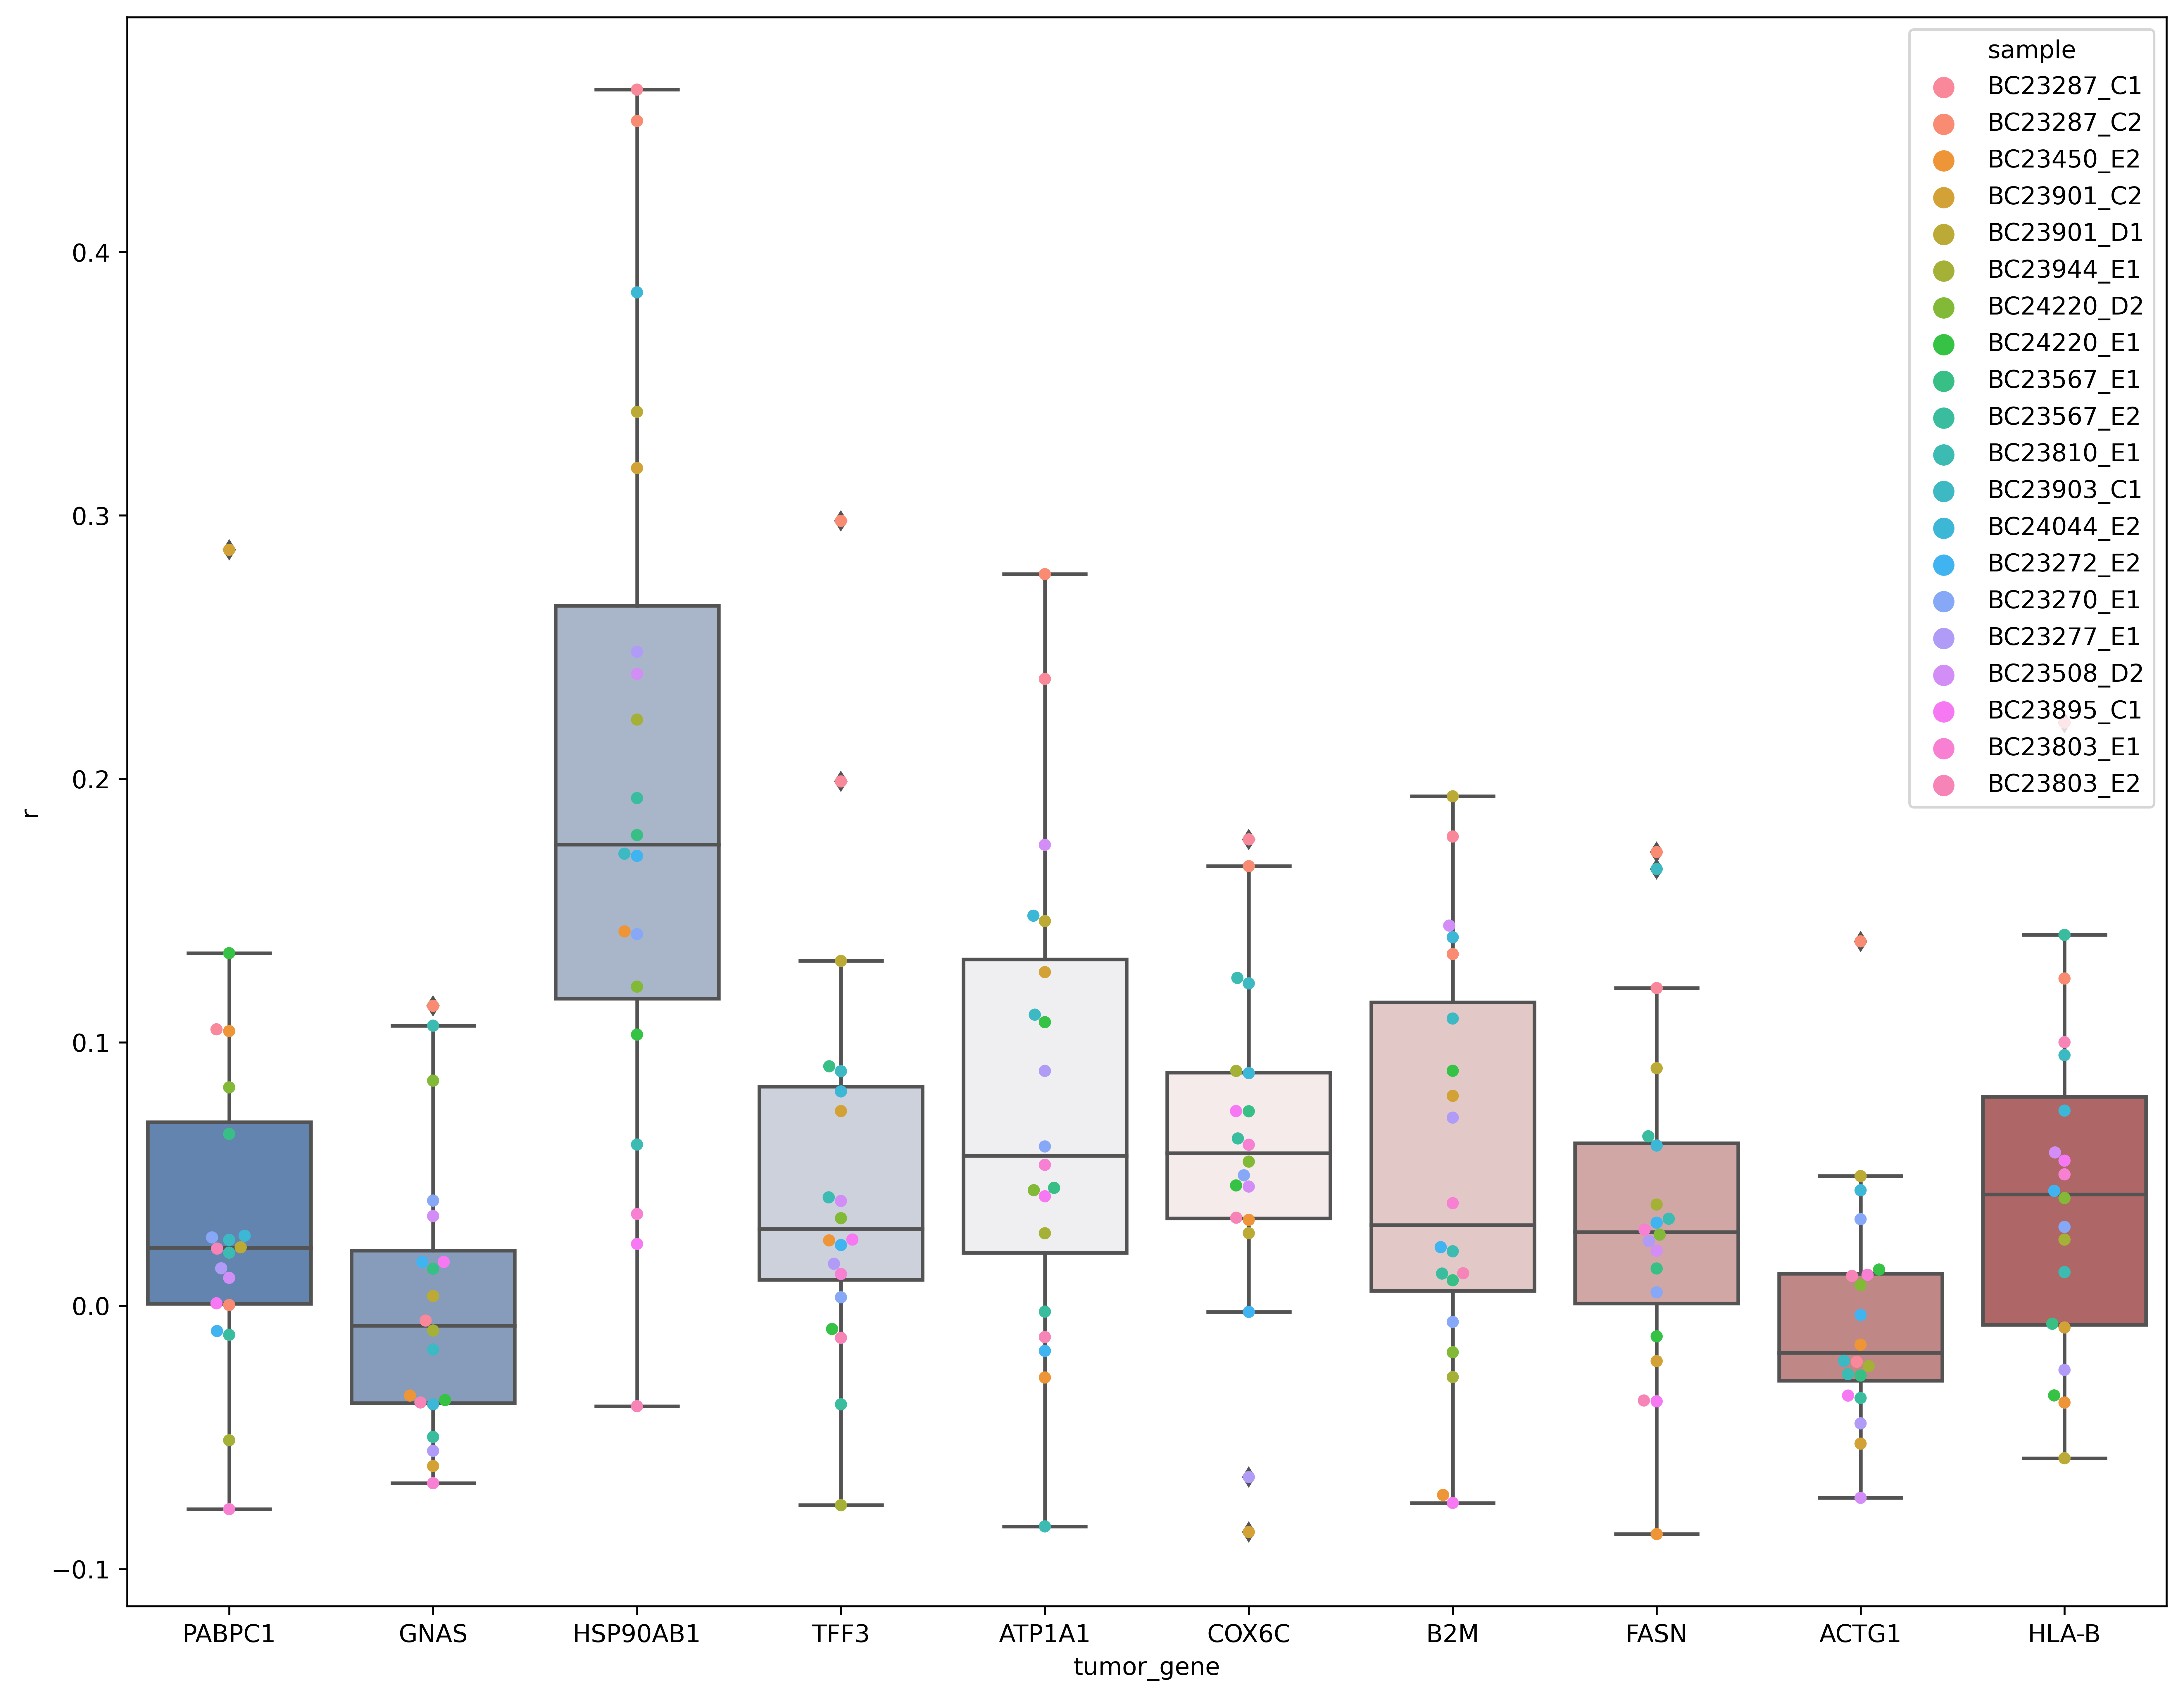

In [36]:
f, ax = plt.subplots(figsize=(15, 12))
sns.boxplot(x="tumor_gene", y="r", data=df, palette="vlag")
sns.swarmplot(x="tumor_gene", y="r", data=df, hue="sample")
plt.show()

In [37]:
f, ax = plt.subplots(figsize=(24, 12))
sns.boxplot(x="sample", y="r", data=df, palette="vlag")
sns.swarmplot(x="sample", y="r", data=df, hue="tumor_gene")
plt.show()

In [38]:
OUT_PATH = Path("/clusterdata/uqxtan9/Xiao/STimage/development/Wiener/resnet50_NB_multi_STnet/test_results_top250")
df = pd.read_csv(OUT_PATH/"r2.csv", index_col=0)

In [39]:
df["r"] = df["R2"]
df["top_250"] = df["tumor_gene"]

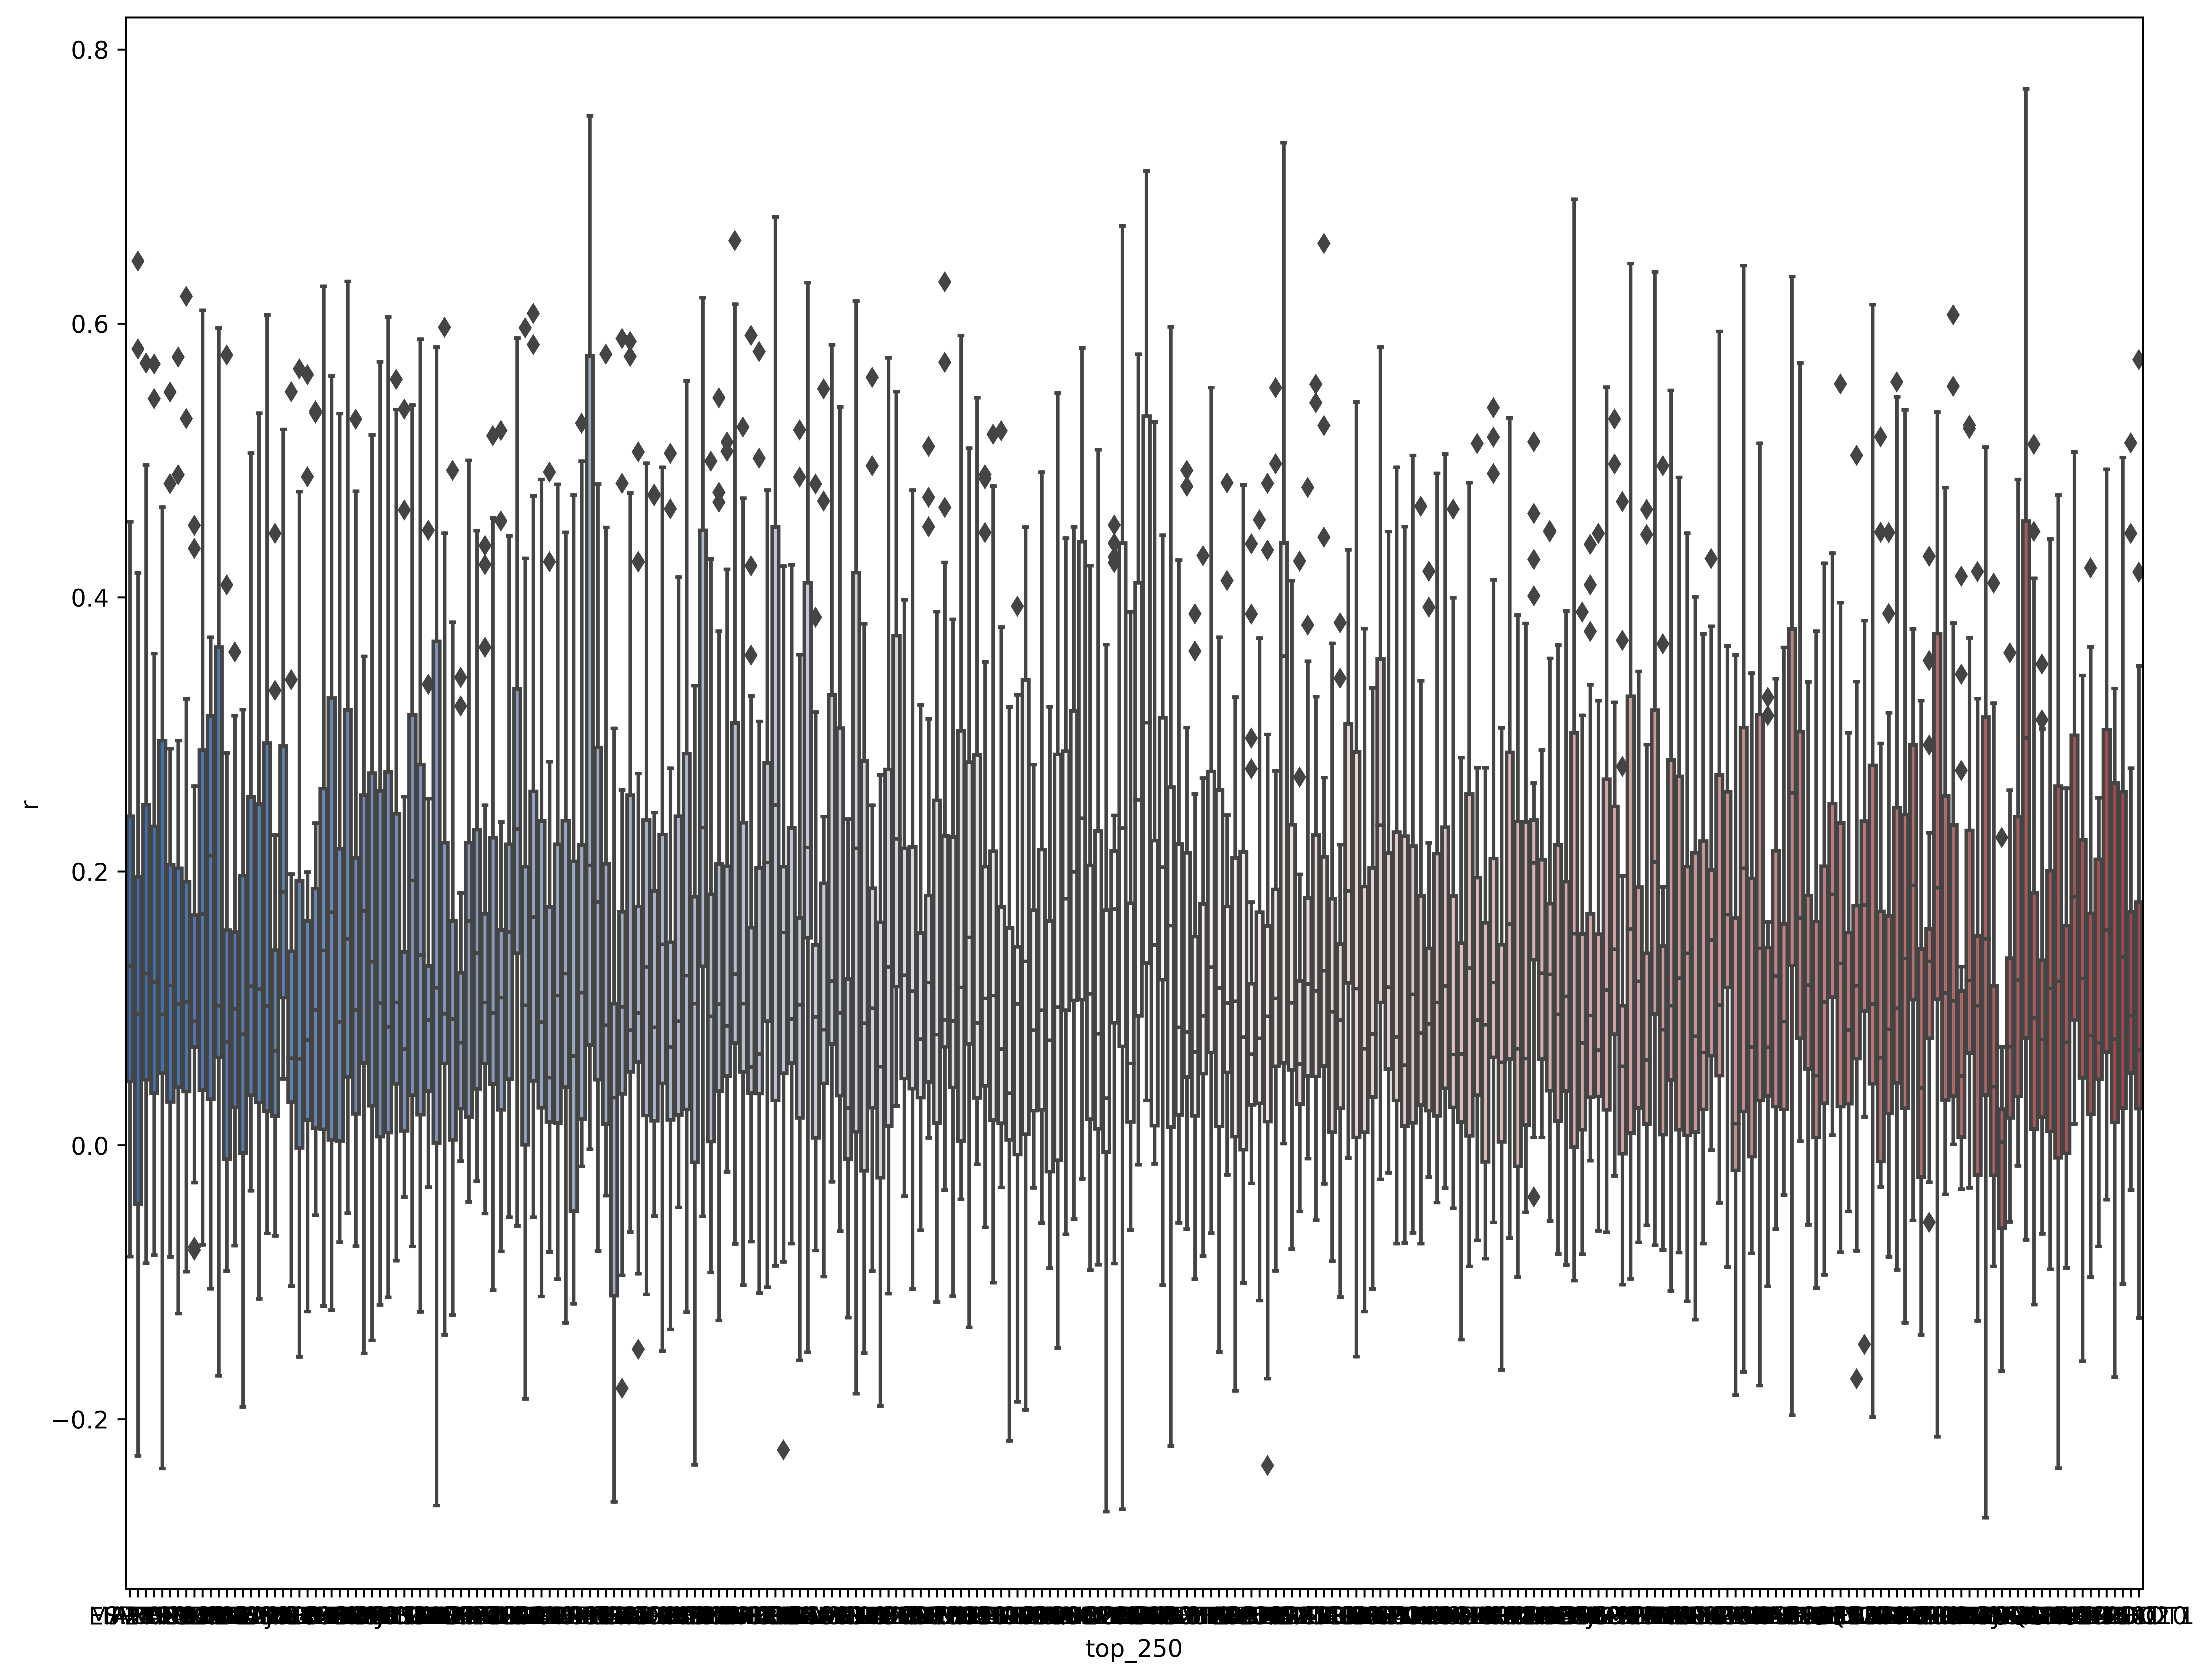

In [40]:
f, ax = plt.subplots(figsize=(15, 12))
sns.boxplot(x="top_250", y="r", data=df, palette="vlag")
# sns.swarmplot(x="tumor_gene", y="r", data=df, hue="sample")
# sns.boxplot(y="r", data=df, palette="vlag")
plt.show()

In [41]:
f, ax = plt.subplots(figsize=(24, 12))
sns.boxplot(x="sample", y="r", data=df, palette="vlag")
# sns.swarmplot(x="sample", y="r", data=df, hue="tumor_gene")
plt.show()

In [63]:
len(df["sample"].unique())

20

In [72]:
df_m =df.groupby(["top_250"]).median()#["r"] >= 0

In [73]:
df_p = df_m[df_m["r"] >= 0]

In [74]:
df_p

,R2,r
top_250,,
ADAMTSL1,0.117817,0.117817
AEBP1,0.136436,0.136436
AKAP8L,0.206562,0.206562
ALG6,0.185836,0.185836
AMD1,0.107223,0.107223
...,...,...
ZNF446,0.211600,0.211600
ZNF497,0.161470,0.161470
ZNF641,0.077803,0.077803


In [70]:
df_p["r"].median()

0.1375730828835841

In [71]:
df_p.sort_values("r", ascending=False)["r"][0:102].median()

0.17307458289757008